# Generate the figures

## Imports

In [174]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import os
import pandas as pd
import muon as mu
import scanpy as sc
import mofax
import anndata as ad

## Load the data

In [187]:
# Define the data and figure folder.
data_folder = "/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/data/"
w_folder = "/users/csb/huizing/Documents/PhD/Code/Mowgli/local_analysis/from_jz/w/"
h_folder = "/users/csb/huizing/Documents/PhD/Code/Mowgli/local_analysis/from_jz/h/"

In [188]:
mdata = mu.read_h5mu(data_folder + "TEA/tea_preprocessed.h5mu.gz")

In [189]:
mdata.obsm["X_mowgli"] = np.load(
    w_folder + "tea_mowgli_cosine_50_0_05_rna_0_01_atac_0_1_adt_0_01_0_001.npy",
    allow_pickle=True,
).item()["W"]
mdata.uns = {}

## Plot the embedding

In [190]:
joint_embedding = ad.AnnData(mdata.obsm["X_mowgli"], obs=mdata.obs)
joint_embedding.obs[mdata["adt"].var_names] = mdata["adt"].X

In [191]:
sc.pp.neighbors(joint_embedding, n_neighbors=25)
sc.tl.umap(joint_embedding)

In [197]:
sc.tl.leiden(joint_embedding, resolution=.2, key_added="leiden")
sc.tl.leiden(joint_embedding, resolution=3, key_added="leiden_precise")

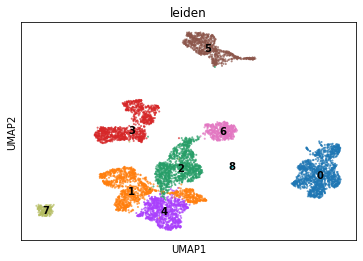

In [198]:
sc.pl.umap(joint_embedding, color="leiden", alpha=.7, legend_loc="on data", save="tea_leiden.pdf")

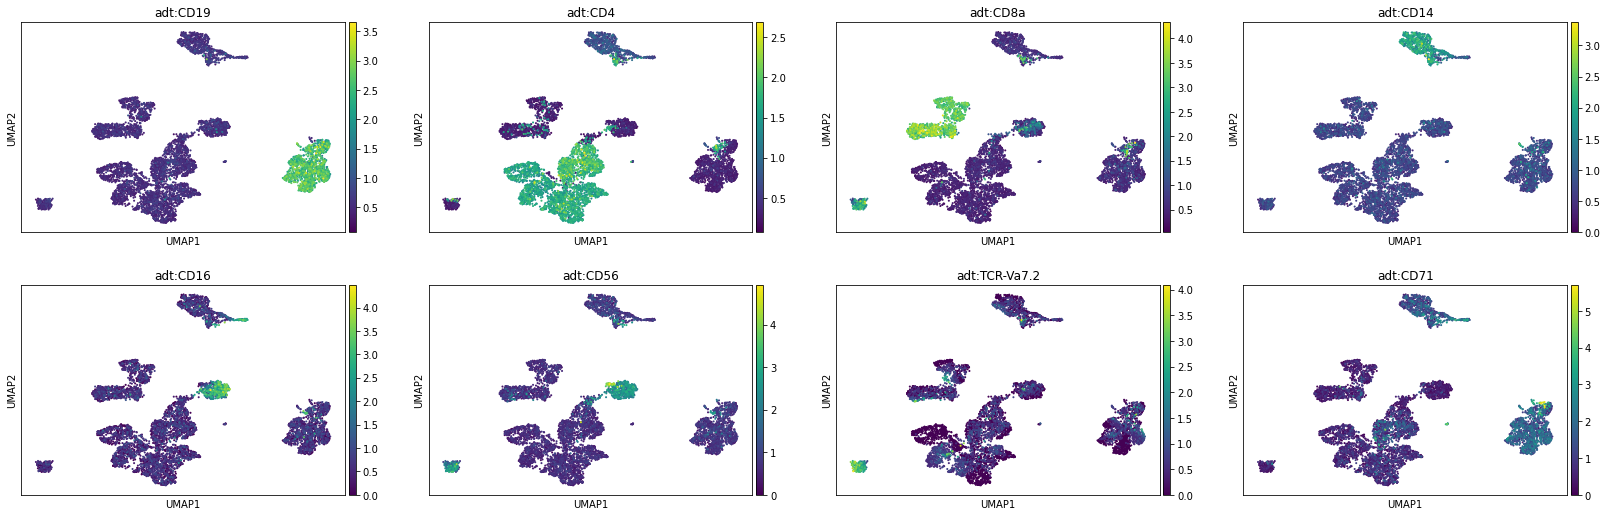

In [201]:
sc.pl.umap(
    joint_embedding,
    color=[
        "adt:CD19", # B cells
        "adt:CD4", # CD4 T cells
        "adt:CD8a", # CD8 T cells
        "adt:CD14", # Monocytes
        "adt:CD16", # Monocytes
        "adt:CD56", # NK cells
        "adt:TCR-Va7.2", # MAIT T cells
        "adt:CD71", # Erythroid cells
    ],
)

In [205]:
cluster_names = {
    0: "B cells",
    1: "CD4 T cells",
    2: "CD4 T cells",
    3: "CD8 T cells",
    4: "CD4 T cells",
    5: "Monocytes",
    6: "NK cells",
    7: "MAIT T cells",
    8: "Erythroid cells",
}
joint_embedding.obs["leiden"] = [cluster_names[c] for c in joint_embedding.obs["leiden"].cat.codes]

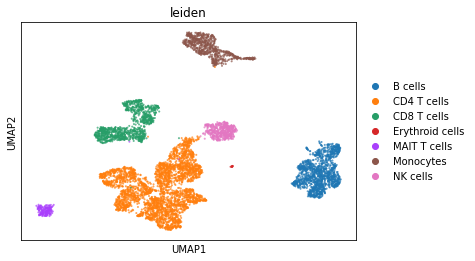

In [208]:
sc.pl.umap(joint_embedding, color="leiden", alpha=.7, save="tea_leiden.pdf")

In [209]:
sc.tl.dendrogram(joint_embedding, groupby="leiden_precise")
joint_embedding.obs["leiden_precise"] = joint_embedding.obs["leiden_precise"].cat.rename_categories(np.argsort(joint_embedding.uns["dendrogram_leiden_precise"]["categories_idx_ordered"]))
joint_embedding = joint_embedding[joint_embedding.obs["leiden_precise"].argsort()]

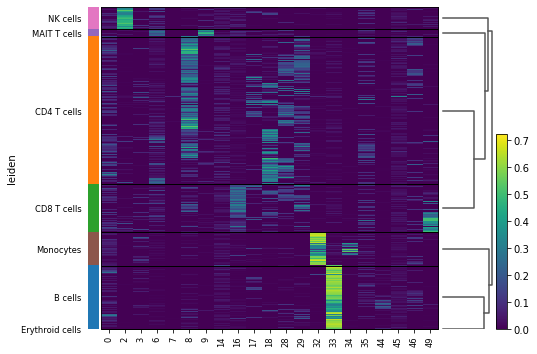

In [227]:
sc.tl.dendrogram(joint_embedding, groupby="leiden")
sc.pl.heatmap(
    joint_embedding,
    var_names=joint_embedding.var_names[joint_embedding.X.max(0) > 0.3],
    groupby="leiden",
    dendrogram=True
)


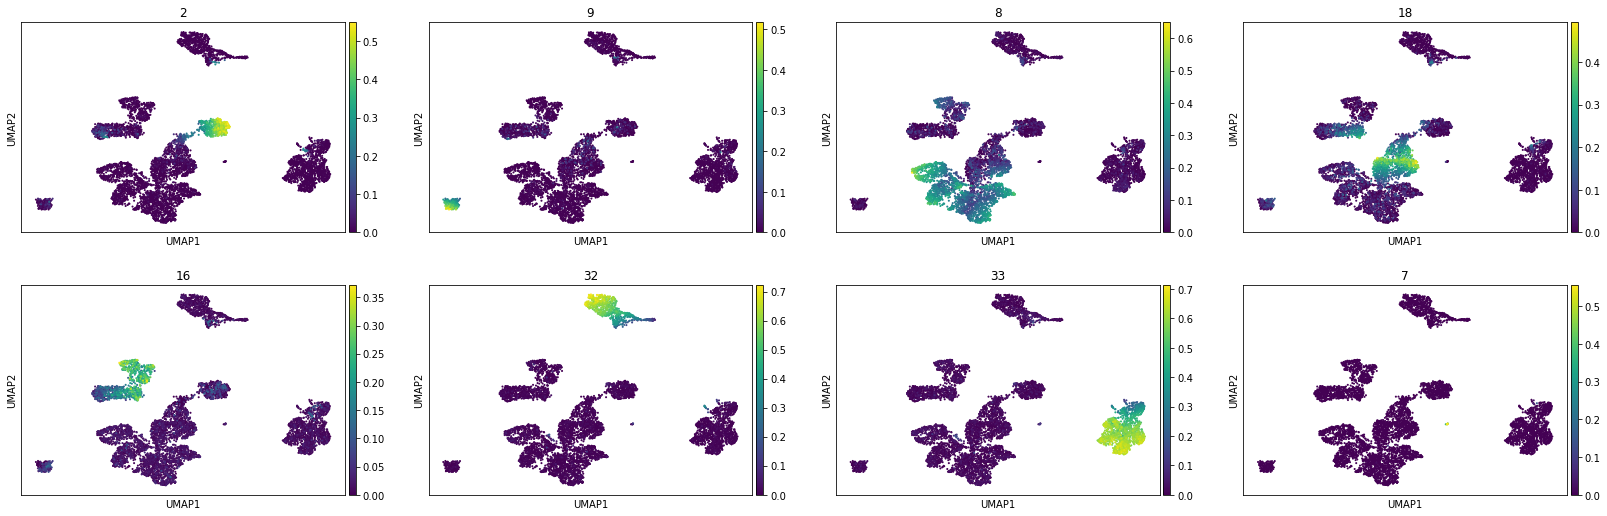

In [214]:
sc.pl.umap(
    joint_embedding,
    color=[
        "2", # NK cells
        "9", # MAIT T cells
        "8", # CD4 T cells
        "18", # CD4 T cells
        "16", # CD8 T cells
        "32", # Monocytes
        "33", # B cells
        "7", # Erythroid cells
    ]
)

## Plot dictionary

In [164]:
H = np.load(
    h_folder + "tea_mowgli_cosine_50_0_05_rna_0_01_atac_0_1_adt_0_01_0_001.npy",
    allow_pickle=True,
).item()

In [307]:
def plot_proteins(dim):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
    idx = H["H_adt"][:, dim].argsort()[::-1]
    labels = mdata["adt"].var_names.str.replace("adt:", "")[idx]
    ax.bar(labels, H["H_adt"][idx, dim])
    ax.set_title(f'Plotting dim {str(dim)}')
    ax.set_xticklabels(labels, rotation=90)
    plt.show()

def plot_genes(dim):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
    idx = H["H_rna"][:, dim].argsort()[::-1]
    ax.plot(H["H_rna"][idx, dim])
    ax.set_title(f'Plotting dim {str(dim)}')
    plt.show()

def plot_peaks(dim):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
    idx = H["H_atac"][:, dim].argsort()[::-1]
    ax.plot(H["H_atac"][idx, dim])
    ax.set_title(f'Plotting dim {str(dim)}')
    plt.show()

def top_proteins(dim, threshold=.5):
    idx = H["H_adt"][:, dim].argsort()
    top_idx = idx[H["H_adt"][idx, dim].cumsum() > threshold][::-1]
    return mdata["adt"].var_names.str.replace("adt:", "")[top_idx].to_numpy(dtype=str)

def top_genes(dim, threshold=.5):
    idx = H["H_rna"][:, dim].argsort()
    top_idx = idx[H["H_rna"][idx, dim].cumsum() > threshold][::-1]
    return mdata["rna"].var_names.str.replace("rna:", "")[top_idx].to_numpy(dtype=str)

def top_peaks(dim, threshold=.5):
    idx = H["H_atac"][:, dim].argsort()
    top_idx = idx[H["H_atac"][idx, dim].cumsum() > threshold][::-1]
    return mdata["atac"].var_names.str.replace("atac:", "")[top_idx].to_numpy(dtype=str)

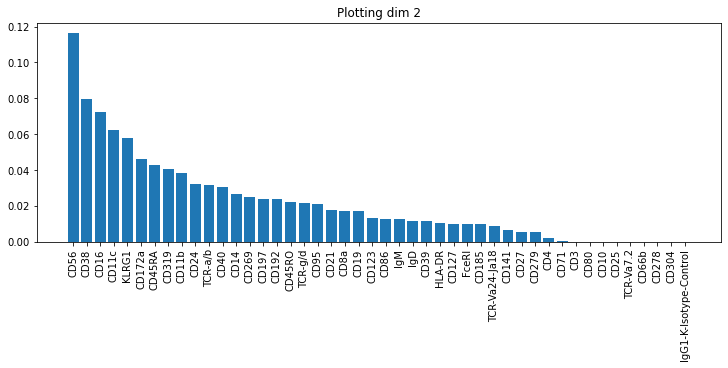

Top proteins: CD56, CD38, CD16, CD11c, KLRG1, CD172a, CD45RA, CD319
Top genes: GNLY, MCTP2, YES1, AOAH, PLCB1, ZEB2, RAP1GAP2, PTPN12, NCALD, BNC2
Top peaks: chr4:8408925-8410213, chr1:184386284-184389026, chr22:37161378-37165123, chr12:121557387-121558559, chr20:38872579-38876222, chr17:17662921-17664193, chr22:23263648-23264676, chr7:74092433-74095372, chr19:10796878-10798373, chr12:128794476-128798200


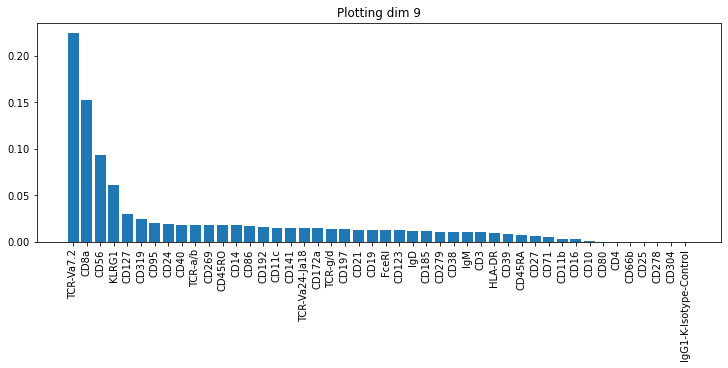

Top proteins: TCR-Va7.2, CD8a, CD56, KLRG1
Top genes: ZBTB16, DLEU1, PHACTR2, PLCB1, SLC4A10, RUNX2, MAN1A1, ERN1, SLC7A5, CYTH3
Top peaks: chr11:114073306-114076321, chr17:3794780-3797254, chr17:82909317-82910155, chr16:17590996-17592356, chr1:57307223-57307988, chr11:114065737-114066743, chr6:167112403-167115173, chr4:26131089-26132323, chr2:86785355-86787189, chr22:44709765-44711773


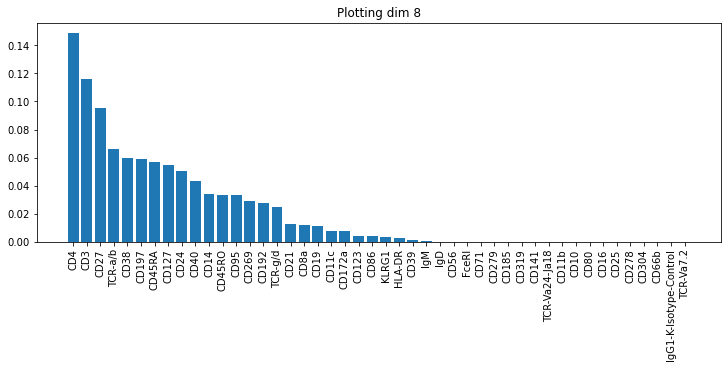

Top proteins: CD4, CD3, CD27, TCR-a/b, CD38, CD197
Top genes: MALAT1, MT-CO2, PRKCH, TSHZ2, BCL11B, MT-ND1, CD247, FHIT, BACH2, PDE3B
Top peaks: chr17:74176996-74177017, chr20:2901289-2901302, chr14:77039541-77041464, chr17:82126302-82128174, chr1:234723095-234725922, chr8:144684197-144688356, chr20:1224477-1227158, chr21:45589899-45592970, chr6:137823641-137825298, chr12:120011680-120015691


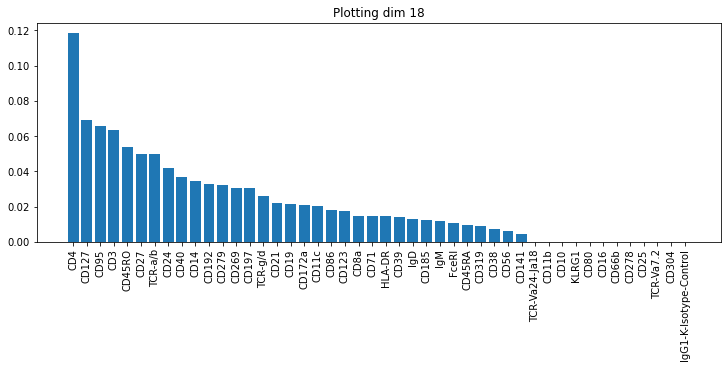

Top proteins: CD4, CD127, CD95, CD3, CD45RO, CD27, TCR-a/b, CD24
Top genes: LMNA, ITGB1, TNFAIP3, PBX4, SAMSN1, NIBAN1, LRIG1, GPRIN3, ANXA1, ANK3
Top peaks: chr12:120011680-120015691, chr9:131666728-131670626, chr1:15948613-15951748, chr20:48768708-48770140, chr22:39089958-39092703, chr17:80891138-80893450, chr9:129866220-129870482, chr15:69467852-69469524, chr3:46947073-46949750, chr16:79598234-79602765


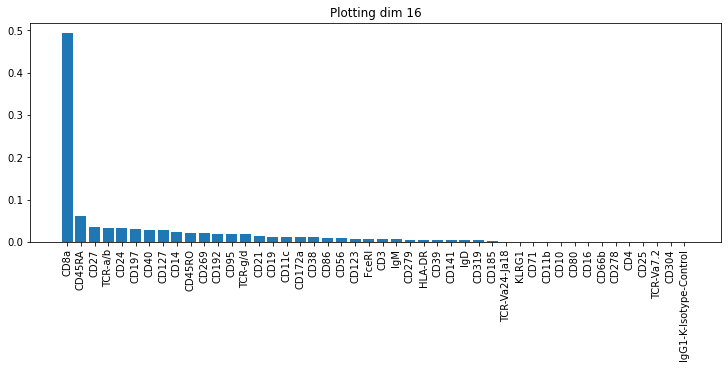

Top proteins: CD8a, CD45RA
Top genes: MALAT1, MT-CO2, MT-ND1, NELL2, PRKCH, PDE3B, BCL11B, BACH2, KLRK1, CAMK4
Top peaks: chr2:86785355-86787189, chr17:74176996-74177017, chr20:2901289-2901302, chr11:66315532-66318943, chr10:132158175-132162575, chr12:10721324-10723787, chr2:86807275-86809907, chr3:49553728-49555305, chr2:241034990-241037472, chr1:24963259-24967301


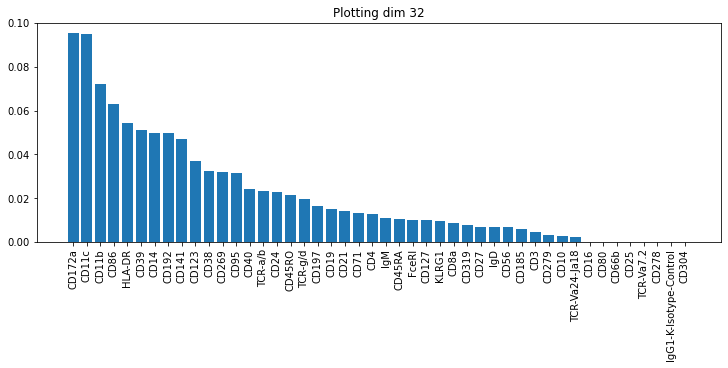

Top proteins: CD172a, CD11c, CD11b, CD86, HLA-DR, CD39, CD14, CD192
Top genes: JARID2, ZEB2, GAB2, ITGAX, RBM47, LRMDA, PTPRE, SLC11A1, ARHGAP26, PTK2B
Top peaks: chr17:74176996-74177017, chr20:2901289-2901302, chr20:40687498-40690954, chr15:70507511-70510172, chr3:46088920-46091418, chr12:54382824-54386099, chr4:7646534-7651079, chr17:74512290-74515467, chr7:151795424-151798297, chr7:101717093-101718814


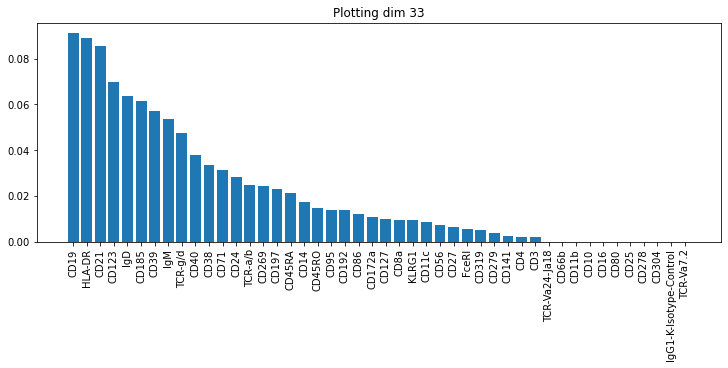

Top proteins: CD19, HLA-DR, CD21, CD123, IgD, CD185, CD39
Top genes: AFF3, BANK1, LYN, AUTS2, ARHGAP24, ADAM28, SIPA1L1, TRIO, COL19A1, GNG7
Top peaks: chr17:74176996-74177017, chr20:2901289-2901302, chr6:167112403-167115173, chr19:2677615-2682203, chr15:74382031-74386562, chr6:150598982-150601209, chr9:123337879-123341080, chr19:13102147-13105863, chr16:67527882-67532349, chr2:231670897-231673760


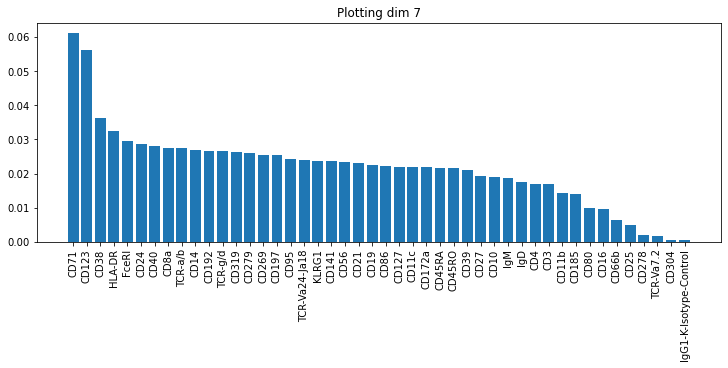

Top proteins: CD71, CD123, CD38, HLA-DR, FceRI, CD24, CD40, CD8a, TCR-a/b, CD14, CD192, TCR-g/d, CD319, CD279, CD269, CD197
Top genes: ATP8B4, CALN1, MED12L, MEIS1, RNF220, NKAIN2, CASC15, TAFA2, ZNF385D, MAML3
Top peaks: chr16:49281723-49282268, chr19:55165848-55167710, chr18:25349450-25352652, chr1:72282271-72284748, chr16:658971-661986, chr7:25862076-25863012, chr10:119028821-119031025, chr7:151050526-151051620, chr17:50917999-50920483, chr4:1791951-1795648


In [315]:
for dim in [2, 9, 8, 18, 16, 32, 33, 7]:
    plot_proteins(dim)
    print("Top proteins:", ", ".join(top_proteins(dim)))
    print("Top genes:", ", ".join(top_genes(dim)[:10]))
    print("Top peaks:", ", ".join(top_peaks(dim)[:10]))

## Enrich

In [425]:
import gget
import pyperclip

In [426]:
pyperclip.copy("\t".join(mdata["rna"].var_names.str.replace("rna:", "")))

In [435]:
pyperclip.copy("\n".join(top_genes(7, threshold=.5)))

In [419]:
def enrich(dim: int, database: str):
    idx = H["H_rna"][:, dim].argsort()[::-1]
    enr = gget.enrichr(top_genes(dim), database)
    enr["min_log_adj_p_val"] = -np.log10(enr["adj_p_val"])
    sns.scatterplot(data=enr.head(), x='min_log_adj_p_val', y='path_name', s=150)
    plt.show()

Mon Aug 29 16:44:32 2022 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Mon Aug 29 16:44:32 2022 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021.


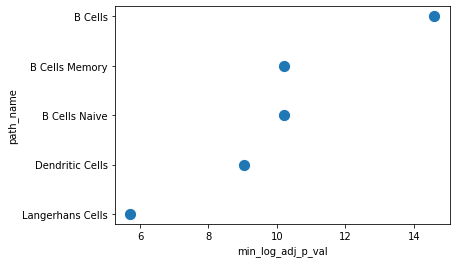

Mon Aug 29 16:44:33 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Mon Aug 29 16:44:33 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


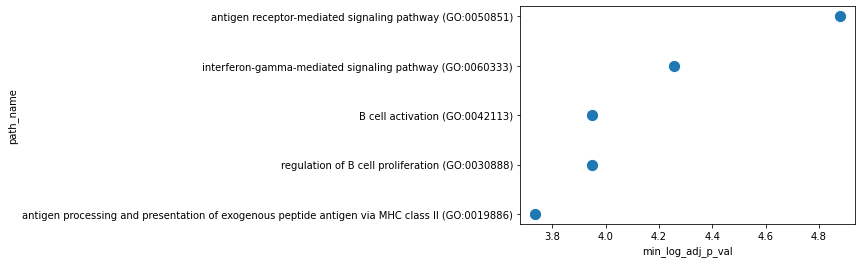

In [420]:
enrich(33, "celltypes")
enrich(33, "ontology")

## Motifs

In [406]:
H_rescaled = H["H_atac"] / H["H_atac"].sum(1).reshape(-1, 1)
for dim in range(50):
    idx = H_rescaled[:, dim].argsort()[::-1][:1_000]
    mdata["atac"].var["top_in_dim_" + str(dim)] = False
    mdata["atac"].var.loc[
        mdata["atac"].var_names[idx].to_numpy(dtype=str),
        "top_in_dim_" + str(dim),
    ] = True


In [407]:
mdata["atac"].var.to_csv('/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/top_var.csv')

In [107]:
# Run R

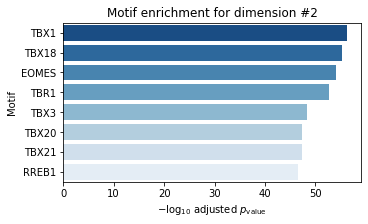

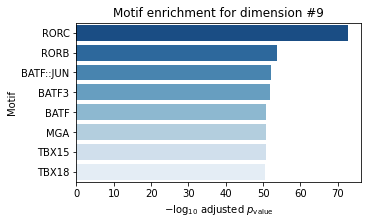

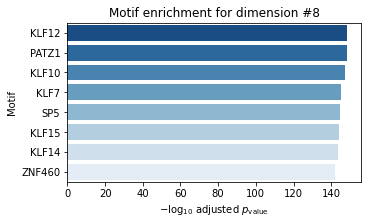

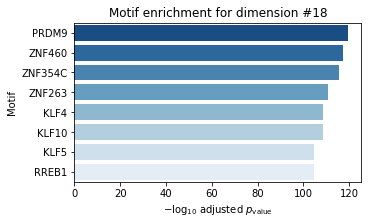

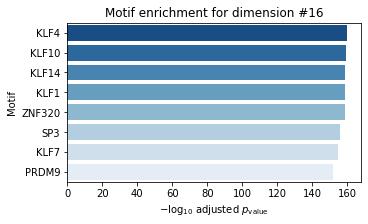

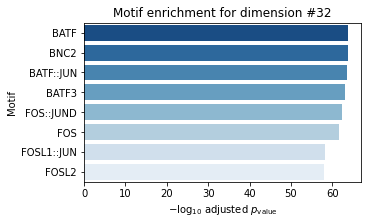

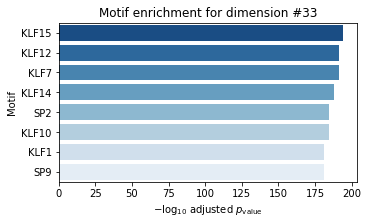

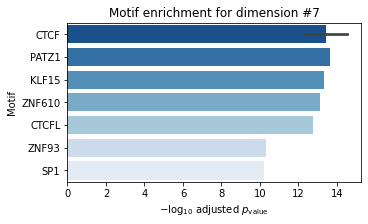

In [410]:
for dim in [2, 9, 8, 18, 16, 32, 33, 7]:

    fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)

    motifs = pd.read_csv(
        f"/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/motifs/motifs_{dim}.csv",
        index_col=0,
    )
    motifs = motifs[motifs["motif"].str.startswith("MA")]
    motifs["minlogp.adjust"] = -np.log10(motifs["p.adjust"])
    sns.barplot(
        data=motifs[:8],
        x="minlogp.adjust",
        y="motif.name",
        ax=ax,
        palette="Blues_r",
    )
    ax.set_title(f"Motif enrichment for dimension #{dim}")
    ax.set_xlabel(r"$-\log_{10}~\mathrm{adjusted}~p_{\mathrm{value}}$")
    ax.set_ylabel("Motif")

    plt.show()
